In [39]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
# import calendar

path_to_data = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-sedelkin/analytics_practice/project_ecommerce/data/'

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

In [2]:
customers = pd.read_csv(path_to_data + 'olist_customers_dataset.csv')
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [3]:
orders = pd.read_csv(path_to_data + 'olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp', \
                                                                             'order_approved_at', \
                                                                             'order_delivered_carrier_date', \
                                                                             'order_delivered_customer_date', \
                                                                             'order_estimated_delivery_date'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [4]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [5]:
customer_order_count = orders.merge(customers, on='customer_id', how='left'). \
    groupby('customer_unique_id'). \
    agg(order_count=('order_id', 'count'))

num_singles = customer_order_count.query('order_count == 1').count()
num_singles

order_count    93099
dtype: int64

Ответ: Сопоставив уникальные ID пользователя с их заказами, используя позаказный ID, получаем что у нас 93 099 пользователя, которые совершили покупку по 1 разу

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [6]:
# Создадим столбец для месяца, приведя дату покупки для заказа к первому числу соответствующего месяца
orders['purchase_month'] = orders.order_purchase_timestamp.to_numpy().astype('datetime64[M]')
# Отберём не доставленные заказы – те заказы, у которых не указана дата доставки 
non_delivered_orders = orders.loc[orders.order_delivered_customer_date.isna()]
# Создадим pivot-таблицу, в которой будет посчитано количество заказов с различным статусом по месяцам
orders_status_pivot = pd.pivot_table(non_delivered_orders, values='order_id', index='purchase_month', columns='order_status', fill_value=0, aggfunc='count')
# Наконец, посчитаем среднее значение для каждого из встречающихся статусов
non_delivered_mean = orders_status_pivot.drop(columns=['delivered']).mean().reset_index()
non_delivered_mean.columns = ['order_status', 'mean']

non_delivered_mean

,order_status,mean
0,approved,0.083333
1,canceled,25.791667
2,created,0.208333
3,invoiced,13.083333
4,processing,12.541667
5,shipped,46.125000
6,unavailable,25.375000


In [7]:
# Чтобы взвесить, насколько долго товар может доставляться, оценим средний срок доставки

mean_delivedy_days = (orders['order_delivered_customer_date'] 
                      - orders['order_purchase_timestamp']) \
                      / np.timedelta64(1, 'D')
mean_delivedy_days.mean().round(1)

12.6

In [8]:
# Проверим дату самого позднего заказ, до сих пор находящийся в статусе "отправлен"
latest_shipped_tz = orders.loc[orders.order_status == 'shipped'].order_purchase_timestamp.max()
latest_shipped_tz

Timestamp('2018-09-03 09:06:57')

In [9]:
# Рассчитаем, сколько дней прошло с даты этого заказа и последнего заказа базе
orders.order_purchase_timestamp.max() - latest_shipped_tz 

Timedelta('44 days 08:23:21')

In [10]:
# Уточним, есть ли "отправленные" заказы, которые не были переданы оператору доставки
orders.loc[(orders.order_status == 'shipped') & (orders.order_delivered_carrier_date.isna())].order_id.count()

0

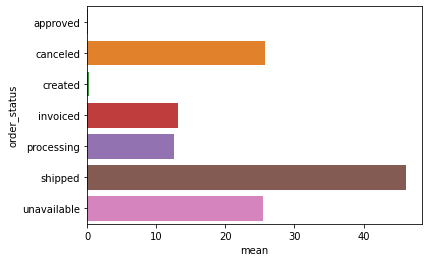

In [11]:
sns.barplot(data=non_delivered_mean, y='order_status', x='mean')

Ответ: 

Наиболее распространённый статус не доставленного заказа – отправлен (shipped). Так как средний срок доставки по доставленным заказам – 12,6 дней, а самый поздний заказ, статус которого "отправлен" – был отправлен полтора месяца назад, можно сделать предположение, что основная причина не доставки – утеря заказов доставщиком после их отправки.

Cледующие по распространённости причины – отмена (canceled) и недоступность заказа (unavailable). За которыми следуют нахождение заказа в статусе выставлен инвойс (invoiced) и обработка (processing). 

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (7 баллов)

In [12]:
order_items = pd.read_csv(path_to_data + 'olist_order_items_dataset.csv')
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Объединим базы товарных позиций и заказов, взяв только столбцы, относящиеся к товарным позициям и дате заказа

In [13]:
items_purchase_dates = order_items[['order_id', 'product_id']]. \
    merge(orders[['order_id', 'order_purchase_timestamp']], on='order_id', how='left')

items_purchase_dates.dtypes

order_id                            object
product_id                          object
order_purchase_timestamp    datetime64[ns]
dtype: object

Приведём дату покупки каждой тованой позиции к дню недели (в виде его порядкового номера).

Для проверки, посмотрим на распределение по дням недели покупок одного из популярных товаров

In [17]:
items_purchase_dates['weekday'] = items_purchase_dates.order_purchase_timestamp.apply(datetime.datetime.weekday)
items_purchase_dates[items_purchase_dates.product_id == '368c6c730842d78016ad823897a372db'].weekday.value_counts()

4    67
1    63
3    58
6    54
2    52
0    50
5    44
Name: weekday, dtype: int64

Ответ: В датафрейме ниже рассчитаем самые популярные дни недели для покупки каждого из товаров, и количество заказов товара в этот день недели. Проверим правильность расчёта, сверив количество продаж с товаром из примера выше (индекс 4).

In [18]:
top_weekdays_by_product = items_purchase_dates. \
    groupby(['product_id', 'weekday']). \
    agg({'order_purchase_timestamp': 'count'}). \
    reset_index(). \
    sort_values(by='order_purchase_timestamp', ascending=False, ignore_index=True). \
    groupby('product_id').head(1). \
    rename(columns={'weekday': 'top_weekday', 
                    'order_purchase_timestamp': 'num_orders'}) \
    .reset_index().drop(columns=['index'])

top_weekdays_by_product

,product_id,top_weekday,num_orders
0,422879e10f46682990de24d770e7f83d,2,93
1,99a4788cb24856965c36a24e339b6058,0,92
2,aca2eb7d00ea1a7b8ebd4e68314663af,3,89
3,53b36df67ebb7c41585e8d54d6772e08,1,76
4,368c6c730842d78016ad823897a372db,4,67
...,...,...,...
32946,6432d844f2be41bb6f2fd279e23415da,4,1
32947,6421ae053bb80dff3ceae1f217f54ed4,0,1
32948,642247ccf62585635cefa1bf09f59b94,1,1
32949,642e125cbc752b4eeb8faf442319c39f,3,1


4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

Добавим к списку заказов уникальные идентификаторы пользователей, объединив датафреймы

In [19]:
customers_orders = customers[['customer_id', 'customer_unique_id']].merge(orders, on='customer_id')

Сгруппируем по месяцам и уникальным ID покупателей, и посчитаем заказы, чтобы получить количество покупок каждого покупателя за месяц.

In [20]:
orders_weekly_count = customers_orders.groupby(['purchase_month', 'customer_unique_id']). \
                        agg(order_count=('order_id', 'count')).reset_index()

Создадим столбец с количеством недель месяце для каждой строки

In [21]:
orders_weekly_count['orders_per_week'] = orders_weekly_count.order_count / (orders_weekly_count.purchase_month.dt.daysinmonth / 7)

Наконец рассчитаем среднее количество покупок в неделю по клиентам по месяцам. Добавим также проверочный столбец, чтобы убедиться что учтены все заказы. При проверке видим что их количество исходное – 99441

In [22]:
weekly_orders = orders_weekly_count.groupby('purchase_month'). \
                    agg(mean_per_week = ('orders_per_week', 'mean'), 
                        total_orders = ('order_count', 'sum')). \
                    reset_index()
weekly_orders.total_orders.sum(axis=0)

99441

Ответ: результат приведён в столбце mean_per_week датфрейма weekly_orders

In [23]:
weekly_orders

,purchase_month,mean_per_week,total_orders
0,2016-09-01,0.233333,4
1,2016-10-01,0.227917,324
2,2016-12-01,0.225806,1
3,2017-01-01,0.236137,800
4,2017-02-01,0.253561,1780
5,2017-03-01,0.229225,2682
6,2017-04-01,0.236481,2404
7,2017-05-01,0.230478,3700
8,2017-06-01,0.238103,3245
9,2017-07-01,0.230326,4026


5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (15 баллов)

В качестве событий, которые которые будем считать как целевые, я выбрал заказы (по дате того события, которое совершается клиентом самостоятельно – покупка). Размер когорты – месяц, а retention буду рассчитывать при помощи повторных заказов тех покупателей, первая покупка которых произошла в определённый месяц. При этом, заказы со статусом "отменён" (canceled) учитываться не будут, так как предполагаем что это те заказы, которые клиент самостоятельно отменил, соответственно, они не должны считаться успешным / целевым событиям. Заказы со статусом "unavailable" я принял решение оставить, так как предполагаю что это заказы, не состоявшиеся не по вине покупателя, и, следственно, их не успешность не должна отражаться на оценке его лояльности. 

In [24]:
customers_orders_narrow = customers_orders.loc[customers_orders.order_status != 'canceled'][['customer_unique_id', 'order_purchase_timestamp', 'purchase_month']]
customers_orders_narrow

,customer_unique_id,order_purchase_timestamp,purchase_month
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,2017-05-01
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,2018-01-01
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,2018-05-01
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,2018-03-01
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,2018-07-01
...,...,...,...
99436,1a29b476fee25c95fbafc67c5ac95cf8,2018-04-07 15:48:17,2018-04-01
99437,d52a67c98be1cf6a5c84435bd38d095d,2018-04-04 08:20:22,2018-04-01
99438,e9f50caf99f032f0bf3c55141f019d99,2018-04-08 20:11:50,2018-04-01
99439,73c2643a0a458b49f58cea58833b192e,2017-11-03 21:08:33,2017-11-01


In [25]:
customer_cohorts = customers_orders_narrow.groupby('customer_unique_id').agg(cohort_month = ('purchase_month', 'min')).reset_index()

In [26]:
customer_cohorts = customer_cohorts.merge(customers_orders_narrow[['customer_unique_id', 'purchase_month']], on = 'customer_unique_id', how = 'left')

In [27]:
customer_cohorts = customer_cohorts.loc[(customer_cohorts.cohort_month >= pd.to_datetime('2017-01-01')) & (customer_cohorts.cohort_month <= pd.to_datetime('2017-12-01'))]
customer_cohorts

,customer_unique_id,cohort_month,purchase_month
2,0000f46a3911fa3c0805444483337064,2017-03-01,2017-03-01
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,2017-10-01
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,2017-11-01
8,0005e1862207bf6ccc02e4228effd9a0,2017-03-01,2017-03-01
10,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07-01,2017-07-01
...,...,...,...
98809,fffbf87b7a1a6fa8b03f081c5f51a201,2017-12-01,2017-12-01
98811,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,2017-06-01
98812,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,2017-12-01
98813,ffff371b4d645b6ecea244b27531430a,2017-02-01,2017-02-01


In [28]:
def get_index(df, col1, col2):

    cohort_year = pd.to_datetime(df[col1]).dt.year
    cohort_month = pd.to_datetime(df[col1]).dt.month
    purchase_year = pd.to_datetime(df[col2]).dt.year
    purchase_month = pd.to_datetime(df[col2]).dt.month
    return (purchase_year - cohort_year) * 12 + purchase_month - cohort_month

customer_cohorts['cohort_index'] = get_index(customer_cohorts, "cohort_month", "purchase_month")
customer_cohorts

,customer_unique_id,cohort_month,purchase_month,cohort_index
2,0000f46a3911fa3c0805444483337064,2017-03-01,2017-03-01,0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,2017-10-01,0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,2017-11-01,0
8,0005e1862207bf6ccc02e4228effd9a0,2017-03-01,2017-03-01,0
10,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07-01,2017-07-01,0
...,...,...,...,...
98809,fffbf87b7a1a6fa8b03f081c5f51a201,2017-12-01,2017-12-01,0
98811,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,2017-06-01,0
98812,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,2017-12-01,0
98813,ffff371b4d645b6ecea244b27531430a,2017-02-01,2017-02-01,0


In [29]:
customer_cohorts.loc[customer_cohorts.cohort_month != customer_cohorts.purchase_month]

,customer_unique_id,cohort_month,purchase_month,cohort_index
107,004288347e5e88a27ded2bb23747066c,2017-07-01,2018-01-01,6
126,004b45ec5c64187465168251cd1c9c2f,2017-09-01,2018-05-01,8
432,011b4adcd54683b480c4d841250a987f,2017-08-01,2018-02-01,6
442,012452d40dafae4df401bced74cdb490,2017-06-01,2018-05-01,11
521,015557c9912277312b9073947804a7ba,2017-03-01,2017-05-01,2
...,...,...,...,...
98248,fe81bb32c243a86b2f86fbf053fe6140,2017-10-01,2018-06-01,8
98355,fed519569d16e690df6f89cb99d4e682,2017-12-01,2018-03-01,3
98634,ff8892f7c26aa0446da53d01b18df463,2017-05-01,2017-11-01,6
98653,ff922bdd6bafcdf99cb90d7f39cea5b3,2017-02-01,2017-09-01,7


In [33]:
cohorts = customer_cohorts.groupby(['cohort_month', 'cohort_index']).agg(customers=('customer_unique_id', 'nunique'))
cohorts['retention_rate'] = cohorts.customers / cohorts.groupby('cohort_month').customers.max() * 100
cohorts

customers  retention_rate
cohort_month cohort_index                           
2017-01-01   0                   762      100.000000
             1                     3        0.393701
             2                     2        0.262467
             3                     1        0.131234
             4                     3        0.393701
...                              ...             ...
2017-12-01   4                    15        0.273773
             5                    11        0.200767
             6                     9        0.164264
             7                     3        0.054755
             8                    12        0.219018

[171 rows x 2 columns]

In [36]:
df = cohorts.reset_index()
third_month = df.loc[df.cohort_index == 3].sort_values('retention_rate', ascending=False).reset_index(drop=True)
third_month['cohort_month'] = pd.to_datetime(third_month['cohort_month']).dt.month
third_month

,cohort_month,cohort_index,customers,retention_rate
0,6,3,13,0.415867
1,5,3,14,0.392047
2,3,3,10,0.384172
3,12,3,19,0.346779
4,9,3,12,0.291829
5,8,3,11,0.264296
6,7,3,10,0.258532
7,4,3,4,0.171380
8,11,3,12,0.165062
9,1,3,1,0.131234


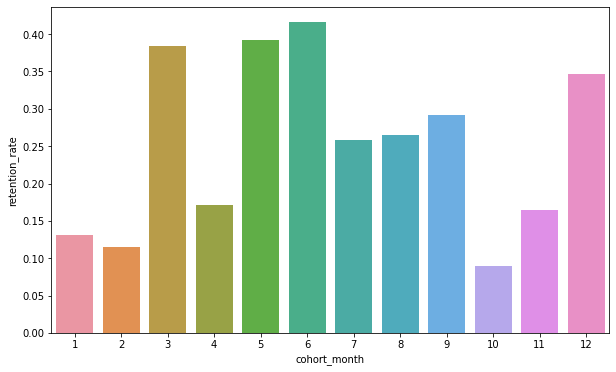

In [41]:
plt.figure(figsize=(10,6))
sns.barplot(data=third_month, x='cohort_month', y='retention_rate')

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. 